# First Assignment
### Giacomo Cristinelli, Camillo Schenone

In [86]:
import math
import matplotlib.pyplot as plt
import numpy as np
from persim import plot_diagrams
from PIL import Image
from ripser import ripser

In [87]:
def drawLineColored(X, C):
    for i in range(X.shape[0]-1):
        plt.plot(X[i:i+2, 0], X[i:i+2, 1], c=C[i, :], linewidth = 2)

def plotCocycle2D(D, X, cocycle, thresh):
    N = X.shape[0]
    t = np.linspace(0, 1, 10)
    c = plt.get_cmap('Greys')
    C = c(np.array(np.round(np.linspace(0, 255, len(t))), dtype=np.int32))
    C = C[:, 0:3]

    for i in range(N):
        for j in range(N):
            if D[i, j] <= thresh:
                Y = np.zeros((len(t), 2))
                Y[:, 0] = X[i, 0] + t*(X[j, 0] - X[i, 0])
                Y[:, 1] = X[i, 1] + t*(X[j, 1] - X[i, 1])
                drawLineColored(Y, C)
    # Plot cocycle projected to edges under the chosen threshold
    for k in range(cocycle.shape[0]):
        [i, j, val] = cocycle[k, :]
        if D[i, j] <= thresh:
            [i, j] = [min(i, j), max(i, j)]
            a = 0.5*(X[i, :] + X[j, :])
            plt.text(a[0], a[1], '%g'%val, color='b')

    #plot vertex labels
    for i in range(N):
        plt.text(X[i, 0], X[i, 1], '%i'%i, color='r')
    plt.axis('equal')
    
def plt_scatter(dset):
    plt.scatter(dset[:, 0], dset[:, 1])
    plt.axis('equal')
    plt.show()

def plt_color(dset, coord, cm='twlight'):
    # colormap with same color at 0 and 1 since we are on R/Z
    cm = plt.cm.get_cmap('twilight')
    sc = plt.scatter(dset[:, 0],dset[:, 1], c=coord, cmap=cm)
    plt.colorbar(sc)
    
def get_highest(dset, n=1):
    # sort them from highest to lowest
    if n == 1:
        return np.argmax(dset)
    else:
        return np.argsort(-dset)[:n]

# Define an epsilon for the [t_birth, t_death) = [t_birth, t_death - eps]
eps = 1e-06

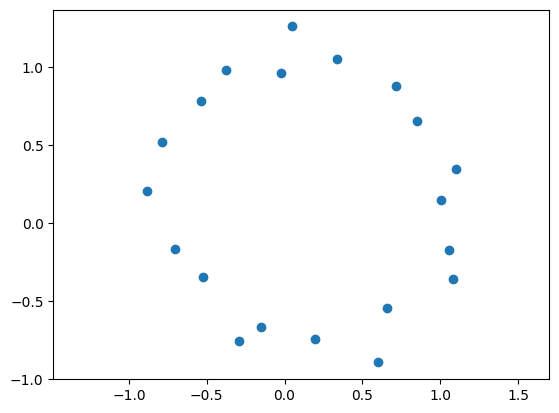

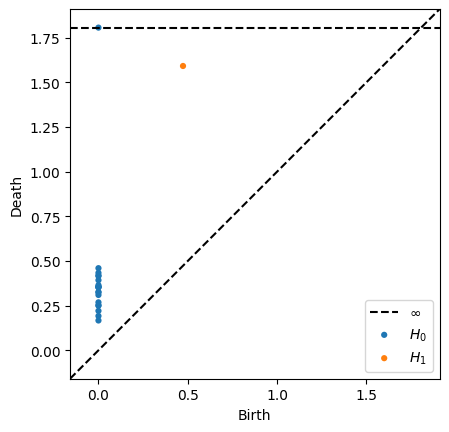

In [88]:
N = 20
t = np.linspace(0, 2*np.pi, N, endpoint=False)

np.random.seed(9) # fix the randomness to be always the same, for reproducibility
dset = np.transpose([np.cos(t), np.sin(t)]) + 0.3*np.random.random((N,2))

p = 41
result = ripser(dset, p, do_cocycles=True)
dgms = result['dgms']
cocycles = result['cocycles']
dist_mat = result['dperm2all']

dgm0 = dgms[0]
dgm1 = dgms[1]

plt_scatter(dset)
plot_diagrams([dgm0, dgm1], show=True)

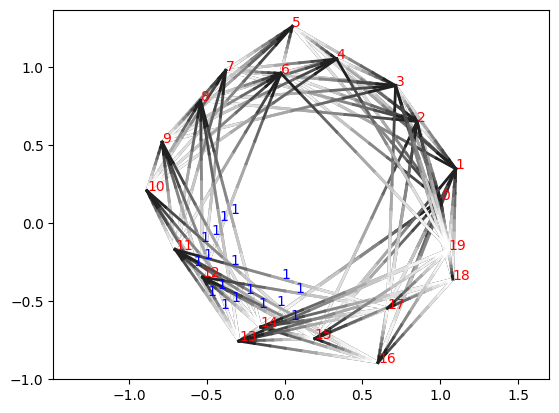

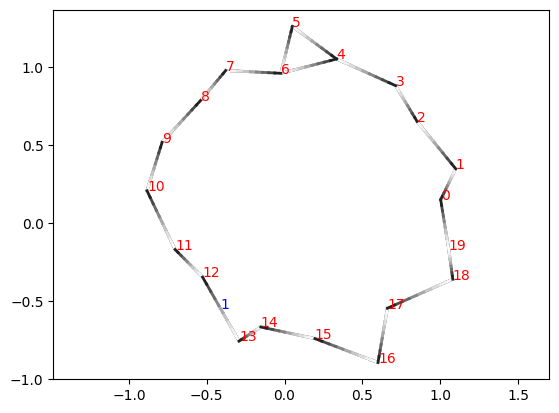

In [89]:
# get longest dimension 1 persistent point
# get index of the longest bar maximum element of the array with elements "end - beginning"
persistence_set = dgm1[:, 1] - dgm1[:, 0]

idx = get_highest(persistence_set)
cocycle = cocycles[1][idx]

t_death = dgm1[idx, 1] - eps # only show edges that have lenght less that the "death time" (which is a distance)
plotCocycle2D(dist_mat, dset, cocycle, t_death)
plt.show()

t_birth = dgm1[idx, 0] + eps
plotCocycle2D(dist_mat, dset, cocycle, t_birth)
plt.show()

# BEGIN

In [90]:
def choose(n, k):
    # binomial
    return int(math.factorial(n) / (math.factorial(k)*math.factorial(n-k)))

def trunc(s, thresh):
    # returns the truncation index for which doing the truncated svd
    for i, k in enumerate(s):
        if k <= thresh:
            return i

def edge_set(N):
    # computes the undirected edges for N vertices
    edges = np.zeros((choose(N, 2), 2), dtype=int) # initialise vector, there are choose(N, 2) undirected edges with N vertices
    idx = 0
    for i in range(0, N-1):
        for j in range(i+1, N):
            edges[idx] = [i, j]
            idx += 1
    return edges

def bonduary_matrix(N, edges):
    # computes the bonduary matrix
    M = np.zeros((N, edges.shape[0]), dtype=int) # initialise |vert| x |edges| matrix
    for i in range(N):
        for j in range(edges.shape[0]):
            # for every row (ith vertex)
            # put 1 for every edge v_*v_i
            # -1 for every edge v_iv_*
            # 0 otherwise
            if i == edges[j, 0]:
                M[i, j] = -1
            elif i == edges[j, 1]:
                M[i, j] = 1
    return M

def convex(thresh, t):
    return t*thresh[1] +(1-t)*thresh[0]

def middle(thresh):
    return convex(thresh, 0.5)

def birth(thresh):
    return convex(thresh, 0)

def death(thresh):
    return convex(thresh, 1)

In [91]:
def circ_coord(D, cocycle, r, p):
    # suppose we already have a simplicial complex and we already computed
    # all the bits we need through ripser, example: the cocycles and the distance metrix
    # suppose also that we already chose a particular point (x,y) and extracted it's cocycle
    # (as shown above) and chose a right threshold.
    # basically point 1 and 2 of the algorthm
    
    N = D.shape[0]
    
    # set up a lookup table to better access the right values of the unlifted cocycle
    cocycle_lookup = {(min(i,j), max(i,j)):val for [i, j, val] in cocycle} 
    
    # compute alpha_r lifted to Z and projected to the edges in the threshold (points 3 and 4)
    edges = edge_set(N) # get edge set from N vertices
    
    # simplicial complex at resolution r
    r_mask = [D[edges[k, 0], edges[k, 1]] <= r for k in range(edges.shape[0])]
    edges_r = np.array([edges[k] for k in range(edges.shape[0]) if r_mask[k]]) # select the right edges
    
    alpha_r = np.zeros(edges_r.shape[0]) # initialise lifted vector in the edge basis
    
    # For each edge, check if the cocycle has a value different than zero, if so lift it to Z, otherwise do nothing.
    for k in range(edges_r.shape[0]):
        [i, j] = edges_r[k]
        try:
            val = cocycle_lookup[(i, j)]
        except:
            val = 0
        if val > 0.5*(p-1): val -= p            
        alpha_r[k] = val
        
    # build bonduary matrix only on the edges at resolution r    
    # bonduary matrix and penrose inverse
    M = np.transpose(bonduary_matrix(N, edges_r))
    u, s, vh = np.linalg.svd(M, full_matrices=False)
    tr_idx = trunc(s, 1e-02) # do a simple truncation of the smallest singular values
    Mdag = np.dot(np.transpose(vh)[:, :tr_idx], np.dot(np.diag(1/s[:tr_idx]), np.transpose(u)[:tr_idx, :]))

    # solve the system and return the circular coordinates
    ys = np.dot(Mdag, -alpha_r) % 1

    return ys

### First Example

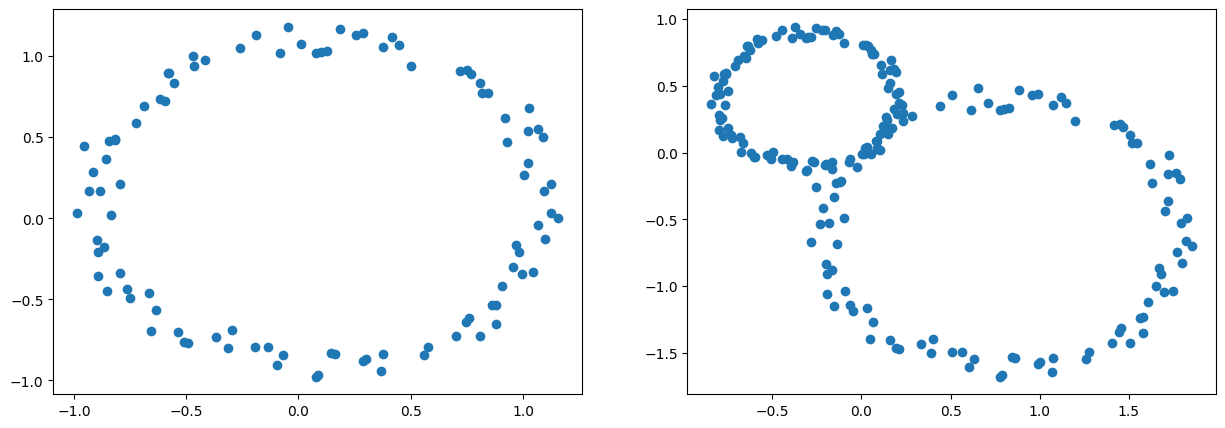

In [92]:
N = 100
t = np.linspace(0, 2*np.pi, N, endpoint=False)

# single circle
np.random.seed(10)
C = np.transpose([np.cos(t), np.sin(t)]) + 0.2 * np.random.random((N,2))


c1 = [0.7, -0.7]
c2 = [-0.7, 0.7]
C1 = 0.5*(C - np.transpose(c1))
C2 = C - np.transpose(c2)

# double circle
CC = np.vstack([C1, C2])

fig, (ax1, ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(15)
ax1.scatter(C[:,0], C[:, 1])
ax2.scatter(CC[:,0], CC[:, 1])

In [93]:
dset = CC

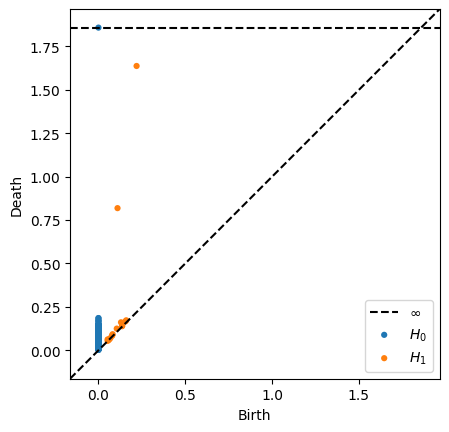

In [94]:
p = 41
result = ripser(dset, coeff=p, do_cocycles=True)
dgms = result['dgms']
cocycles = result['cocycles']
dist_mat = result['dperm2all']

dgm0 = dgms[0]
dgm1 = dgms[1]

# plot diagrams of dimension 0 and 1
plot_diagrams([dgm0, dgm1], show=False)

In [95]:
sorted_idx = np.argsort(dgm1[:, 0] - dgm1[:, 1])

# obtain most persistent point for 1-simplices
# highest persistence
idx = sorted_idx[0]

#second highest
idx2 = sorted_idx[1]

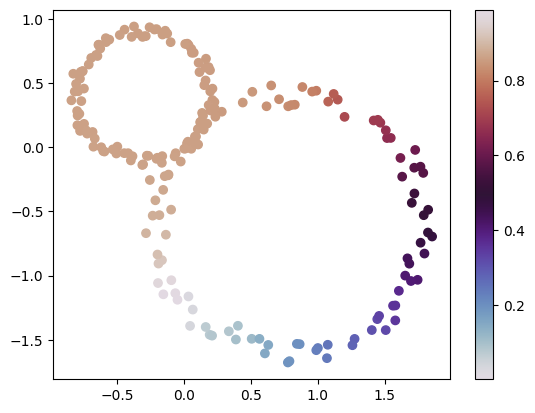

In [96]:
cocycle = cocycles[1][idx]

# get time of death and birth
thresh = (dgm1[idx, 0], dgm1[idx, 1] - eps)
r = middle(thresh)

# get circular coordinates
coord = circ_coord(dist_mat, cocycle, r, p)
    
plt_color(dset, coord)

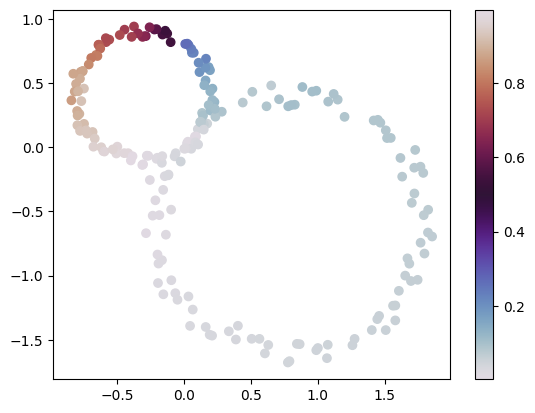

In [97]:
cocycle = cocycles[1][idx2]

# get time of death and birth
thresh = (dgm1[idx, 0], dgm1[idx, 1] - eps)
r = middle(thresh)

# get circular coordinates
coord = circ_coord(dist_mat, cocycle, r, p)

plt_color(dset, coord)

## Flat Torus Example

In [98]:
def torus_norm(p, q):
    x1, y1 = p
    x2, y2 = q
    dx = np.abs(x2-x1)
    dy = np.abs(y2-y1)
    if dx > 0.5: dx = 1 - dx
    if dy > 0.5: dy = 1 - dy
    
    return np.sqrt(dx**2 + dy**2)

def distance_mat(dset):
    n = dset.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = torus_norm(dset[i, :], dset[j, :])
            D[j, i] = D[i, j]
    return D

def to3D(data):
    T3D=np.zeros((data.shape[0],3), dtype=float)
    for i in range(T3D.shape[0]):
        T3D[i][0]= (2 + np.cos(2*np.pi*data[i][0])) * np.cos(2*np.pi*data[i][1])
        T3D[i][1]=(2 + np.cos(2*np.pi*data[i][0])) * np.sin(2*np.pi*data[i][1])
        T3D[i][2]= np.sin(2*np.pi*data[i][0])
    return T3D

def plot3d(data, fig=None, ax=None, **params):
    fig = fig if fig else plt.figure()

    ax = ax if ax else fig.add_subplot(111, projection="3d")
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], **params)
    return ax

__all__ = ["plot3d"]

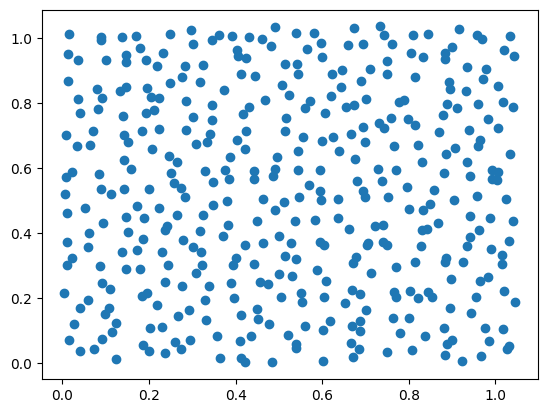

In [99]:
n=20 #n*n points in the torus.
t = np.linspace(0,1,n)
x, y = np.meshgrid(t,t)
x = np.reshape(x, (n*n,1))
y = np.reshape(y, (n*n,1))
T = np.hstack([x, y]) + 0.05*np.random.random((n*n,2))

plt.scatter(T[:, 0], T[:, 1])
plt.show()

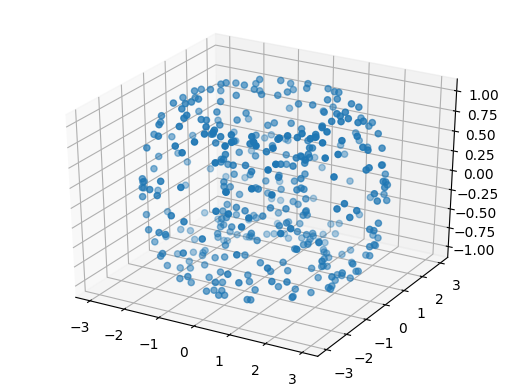

In [100]:
plot3d(to3D(T))

In [101]:
dist_mat = distance_mat(T)

In [102]:
p = 41
result = ripser(dist_mat, coeff=p, do_cocycles=True, distance_matrix=True)
diagrams = result['dgms']
cocycles = result['cocycles']

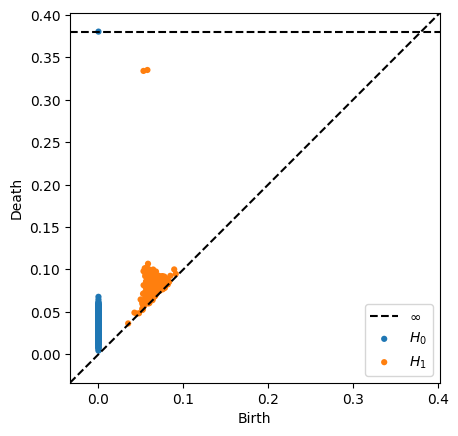

In [103]:
# Dimension 0 and 1 diagrams
dgm0 = diagrams[0]
dgm1 = diagrams[1]

# plot diagrams of dimension 0 and 1
plot_diagrams([dgm0, dgm1], show=False)

In [104]:
sorted_idx = np.argsort(dgm1[:, 0] - dgm1[:, 1])

# top n cocycles
n = 2 # first and second most persistent cocycle
idxs = sorted_idx[:n]

In [105]:
# respective cocycles
top_cocycles = [cocycles[1][idx] for idx in idxs]
thresholds = [(dgm1[idx, 0], dgm1[idx, 1] - 1e-08) for idx in idxs ]

# one threshold for each one of them
rs = [convex(thresholds[i], 0.5) for i in range(n)]

# one threshold for all of them at once since the cocycles have the same lenghts.
death_birth_rateo = 0.5 # 0 at birth, 1 at death
overlap = (max(np.array(thresholds)[:, 0]), min(np.array(thresholds)[:, 1]))
if overlap[1] >= overlap[0] : r = convex(overlap, death_birth_rateo)

In [106]:
# lets use only one generic resolution
coords = [circ_coord(dist_mat, top_cocycles[i], r, p) for i in range(n)]

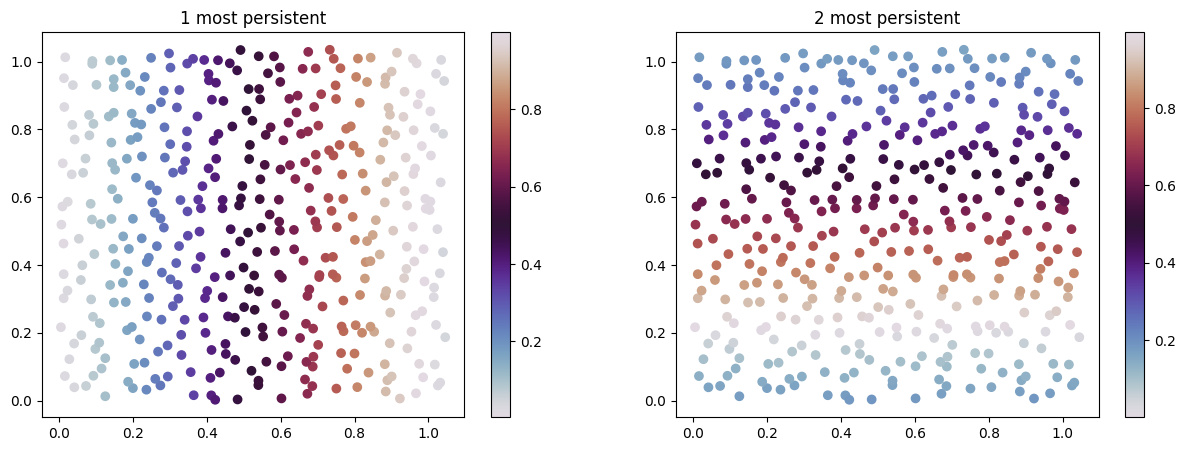

In [107]:
rows = 1
cols = np.ceil(n/rows)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
cm = plt.cm.get_cmap('twilight')
for i in range(n):
    f = fig.add_subplot(rows, cols, i+1)
    sc = plt.scatter(T[:, 0],T[:, 1], c=coords[i], cmap=cm)
    f.set_title(f"{i+1} most persistent")
    plt.colorbar(sc)

## Image Data
#### Object: Vaseline

In [108]:
def pltim(im, h=8, **kwargs):
    # Helper function to plot an image.
    y = im.shape[0]
    x = im.shape[1]
    w = (y/x) * h
    plt.figure(figsize=(w,h))
    plt.imshow(im, interpolation="none", **kwargs)
    plt.axis('off')

def show_images(images, rows = 1, titles = None):
    n = len(images)
    cols = np.ceil(n/rows)
    if titles is None: titles=[f"{i}" for i in range(1,n+1)]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i, (im, t) in enumerate(zip(images, titles)):
        f = fig.add_subplot(rows, cols, i+1)    
        f.set_title(t)
        plt.imshow(im)
        plt.axis('off')
        
    plt.show()

def grid_scatter(dset, rows = 1, titles = None, color=None, color_map='twilight'):
    n = len(dset)
    cols = np.ceil(n/rows)
    if titles is None: titles=[f"{i}" for i in range(1,n+1)]
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    cm = plt.cm.get_cmap(color_map)
    for i, (d, t) in enumerate(zip(dset, titles)):
        f = fig.add_subplot(rows, cols, i+1)    
        f.set_title(t)
        if color is not None:
            sc = plt.scatter(d[:, 0], d[:, 1], c=color[i], cmap=cm)
            plt.colorbar(sc)
        else:
            sc = plt.scatter(d[:, 0], d[:, 1])
        
    plt.show()


In [109]:
# choose object: 1:hearth-piggy 2:medicine 3:car 4:vaseline 5:wood-shapes
obj = 2
num_imgs = 72
image_set = np.array([plt.imread(f"coil-20-unproc/obj{obj}/obj{obj}__{k}.png") for k in range(num_imgs)])

In [110]:
dist_mat = np.zeros((num_imgs, num_imgs))
for i in range(0, num_imgs):
    for j in range(0, num_imgs):
        dist_mat[i,j] = np.linalg.norm(image_set[i]-image_set[j])
        dist_mat[j,i] = dist_mat[i, j]

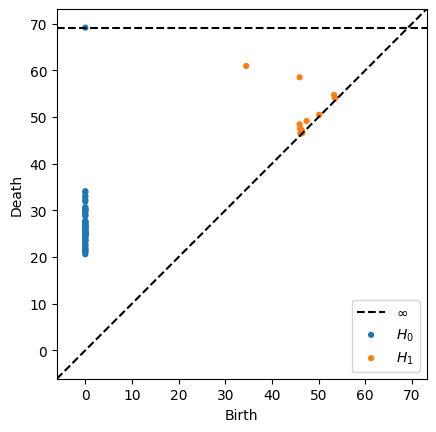

In [111]:
p = 41
result = ripser(dist_mat, coeff=p, do_cocycles=True, distance_matrix=True)
diagrams = result['dgms']
cocycles = result['cocycles']

dgm0 = diagrams[0]
dgm1 = diagrams[1]

plot_diagrams(diagrams, show=False)

In [112]:
sorted_idx = np.argsort(dgm1[:, 0] - dgm1[:, 1])
# most persistent cocycle
idx = sorted_idx[0]

cocycle = cocycles[1][idx]
thresh = (dgm1[idx, 0], dgm1[idx, 1] - eps)
r = middle(thresh)

coord = circ_coord(dist_mat, cocycle, r, p)

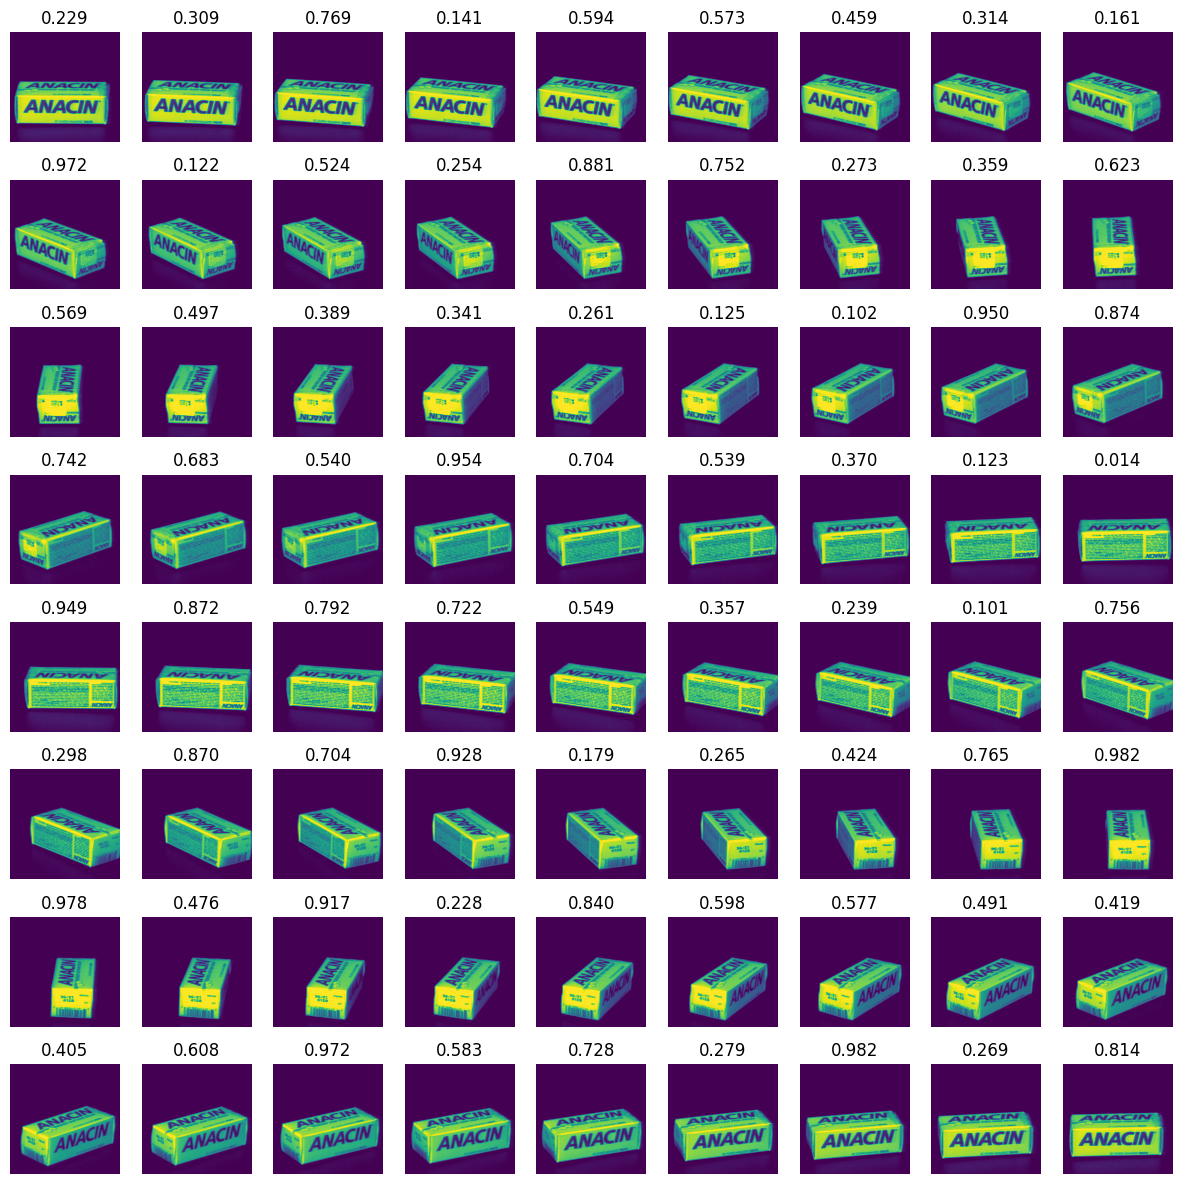

In [113]:
titles = ["%.3f" %c for c in coord]
cropped_image_set = [im[140:350, 120:330] for im in image_set]
show_images(cropped_image_set, rows=8, titles=titles)

#### Full Set

In [114]:
full_image_set = np.array([plt.imread(f"coil-20-unproc/obj{obj}/obj{obj}__{k}.png") for obj in range(1,6) for k in range(num_imgs)])
n = full_image_set.shape[0]

full_dist_mat = np.zeros((n, n))
for i in range(0, n):
    for j in range(0, n):
        full_dist_mat[i,j] = np.linalg.norm(full_image_set[i]-full_image_set[j])
        full_dist_mat[j,i] = full_dist_mat[i, j]

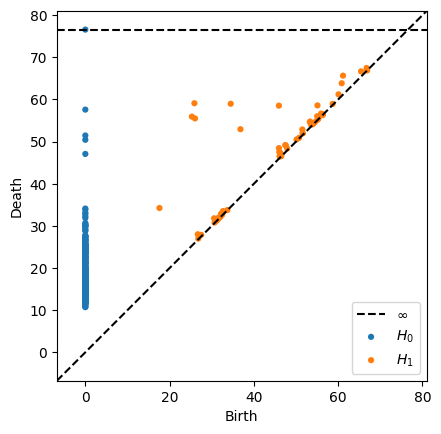

In [115]:
p = 41
result = ripser(full_dist_mat, coeff=p, do_cocycles=True, distance_matrix=True)
diagrams = result['dgms']
cocycles = result['cocycles']

dgm0 = diagrams[0]
dgm1 = diagrams[1]

plot_diagrams(diagrams, show=False)

In [116]:
sorted_idx = np.argsort((dgm1[:, 0] - dgm1[:, 1])/dgm1[:, 0])
# top 5 in persistence
top_n = 5
idxs = sorted_idx[:top_n]

top_cocycles = [cocycles[1][idx] for idx in idxs]
spans = [(dgm1[idx, 0], dgm1[idx, 1] - eps) for idx in idxs]
rs = [middle(span) for span in spans]

coords = np.array([circ_coord(full_dist_mat, cocycle, r, p) for (cocycle, r) in zip(top_cocycles, rs)])

In [117]:
from sklearn.preprocessing import StandardScaler
import sklearn.decomposition as deco

In [118]:
pca = deco.PCA(n_components=2)

flattened_image_set = np.array([im.flatten() for im in full_image_set])

# unscaled whole image set 
unscaled_pca_image_set = pca.fit_transform(flattened_image_set)

# separated objects
separated_unscaled_objset = [unscaled_pca_image_set[i*72:72*(i+1), :] for i in range(5)]

# scaled objects
objsets = [flattened_image_set[i*72:72*(i+1), :] for i in range(5)]
scaled_objs_image_set = [StandardScaler().fit_transform(objsets[i]) for i in range(5)]
scaled_objs_pca_image_set = [pca.fit_transform(scaled_objs_image_set[i]) for i in range(5)]

# all scaled objects joint together in the same plot. messy.
scaled_joint_pca_image_set = np.vstack(scaled_objs_pca_image_set)


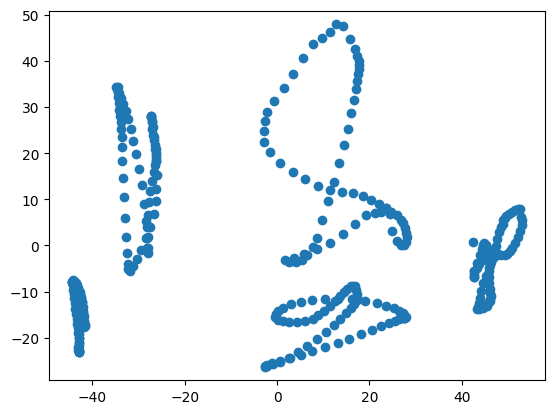

In [119]:
plt_scatter(unscaled_pca_image_set)

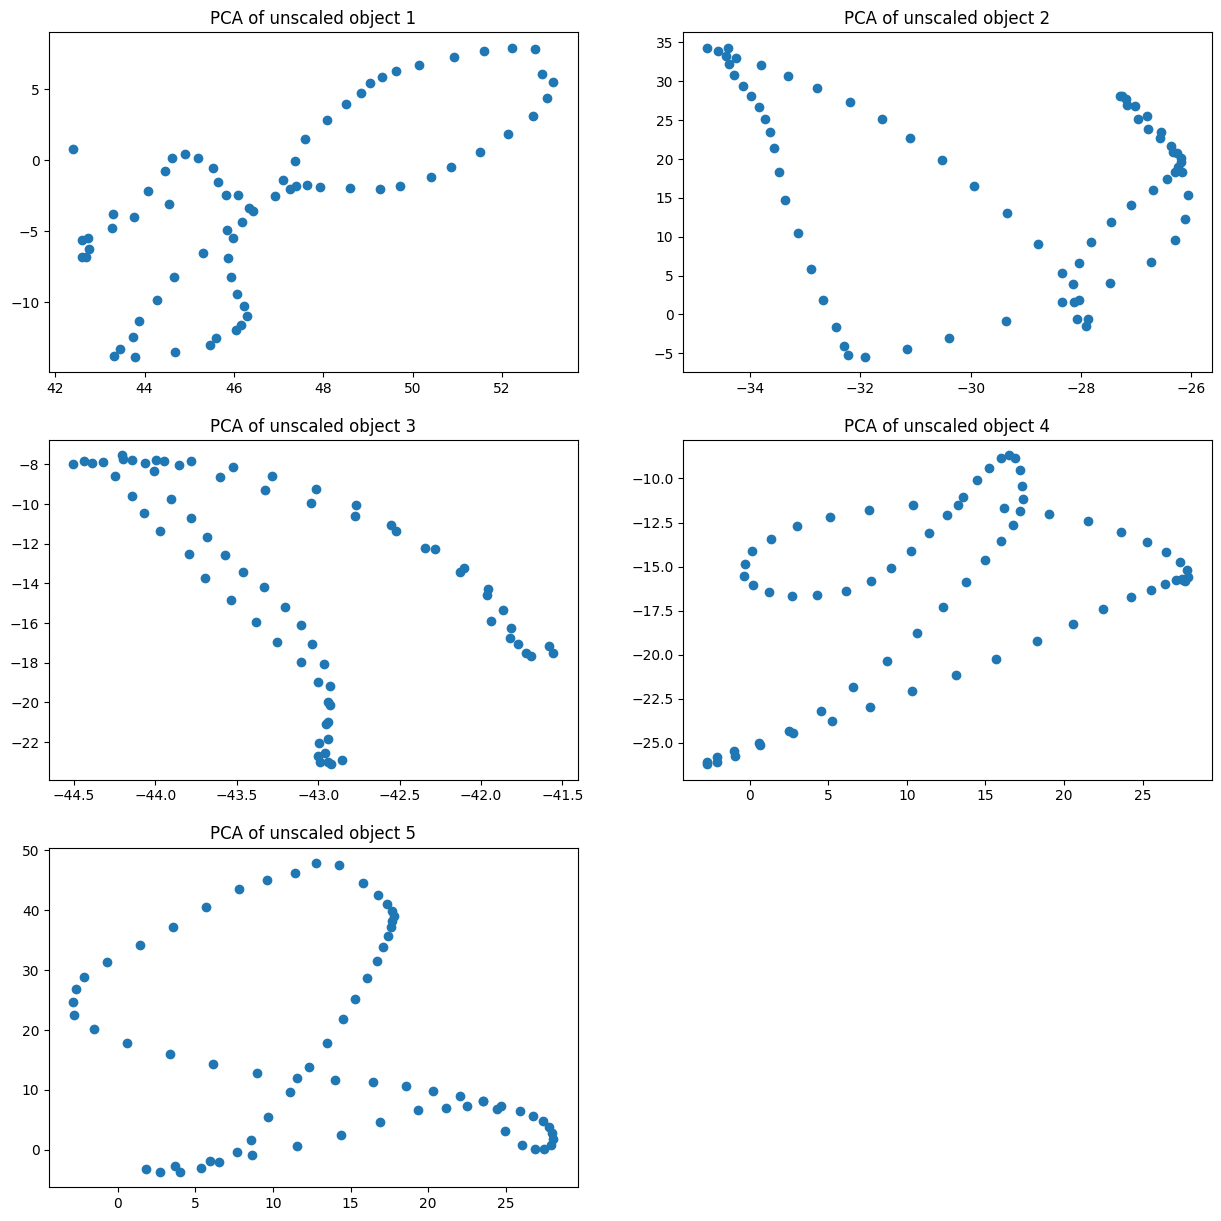

In [120]:
titles = [f"PCA of unscaled object {i}" for i in range(1, 6)]
grid_scatter(separated_unscaled_objset, rows=3, titles = titles)

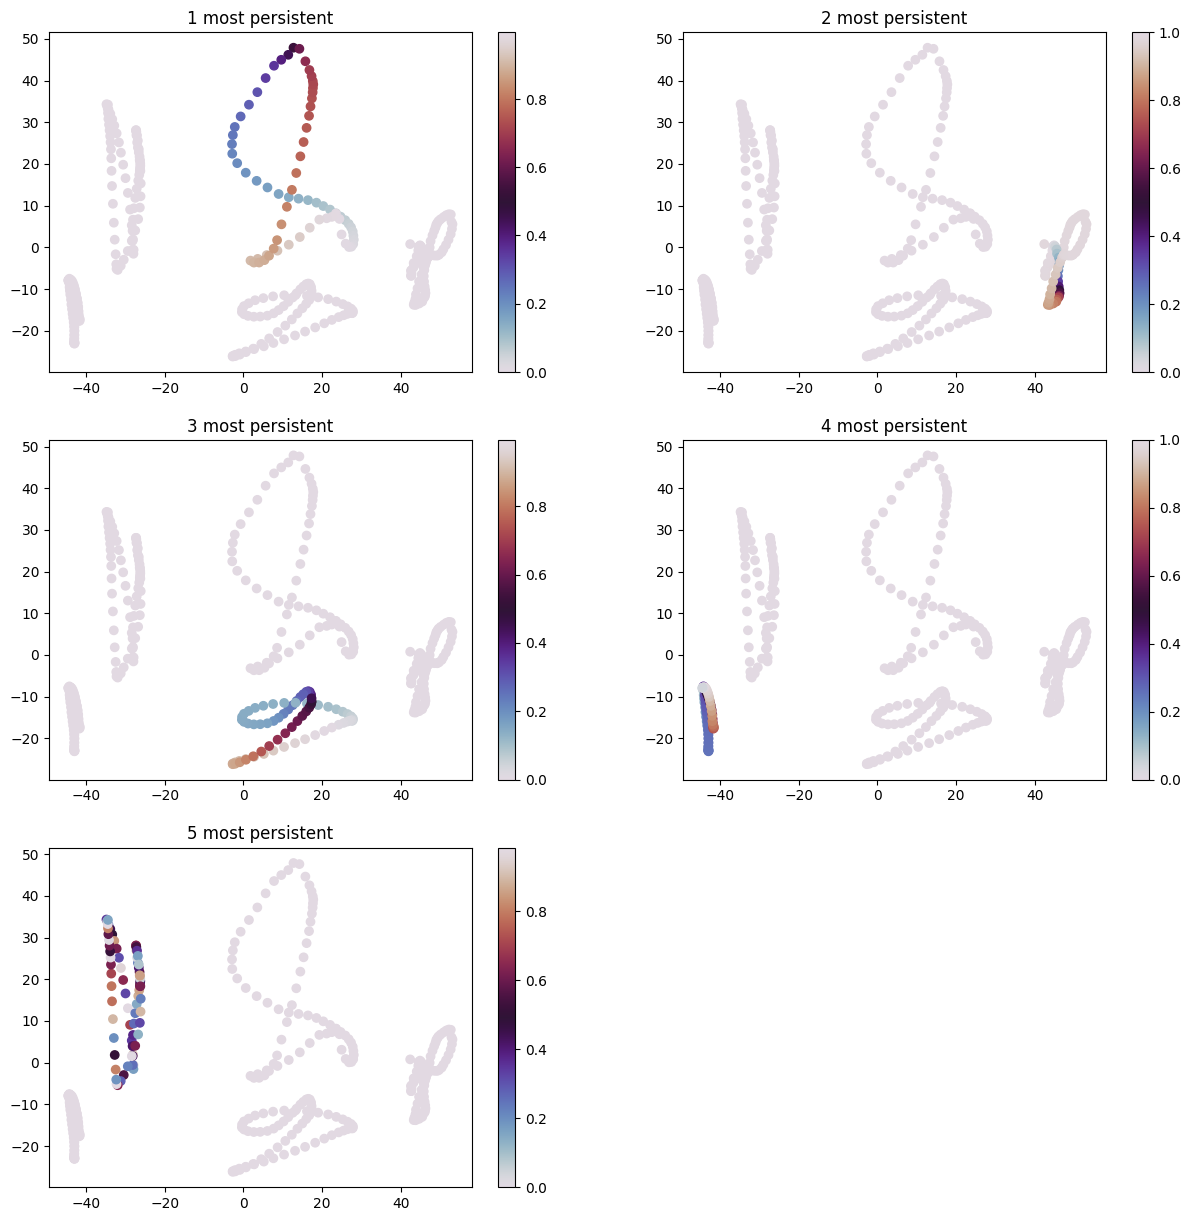

In [121]:
dset = unscaled_pca_image_set

rows = 3
n = len(coords)
cols = np.ceil(n/rows)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
cm = plt.cm.get_cmap('twilight')
for i in range(n):
    f = fig.add_subplot(rows, cols, i+1)
    sc = plt.scatter(dset[:, 0],dset[:, 1], c=coords[i], cmap=cm)
    f.set_title(f"{i+1} most persistent")
    plt.colorbar(sc)

plt.show()

# persistence leaderboard:
# - 1: Object 5
# - 2: Object 1
# - 3: Object 4
# - 4: Object 3
# - 5: Object 2

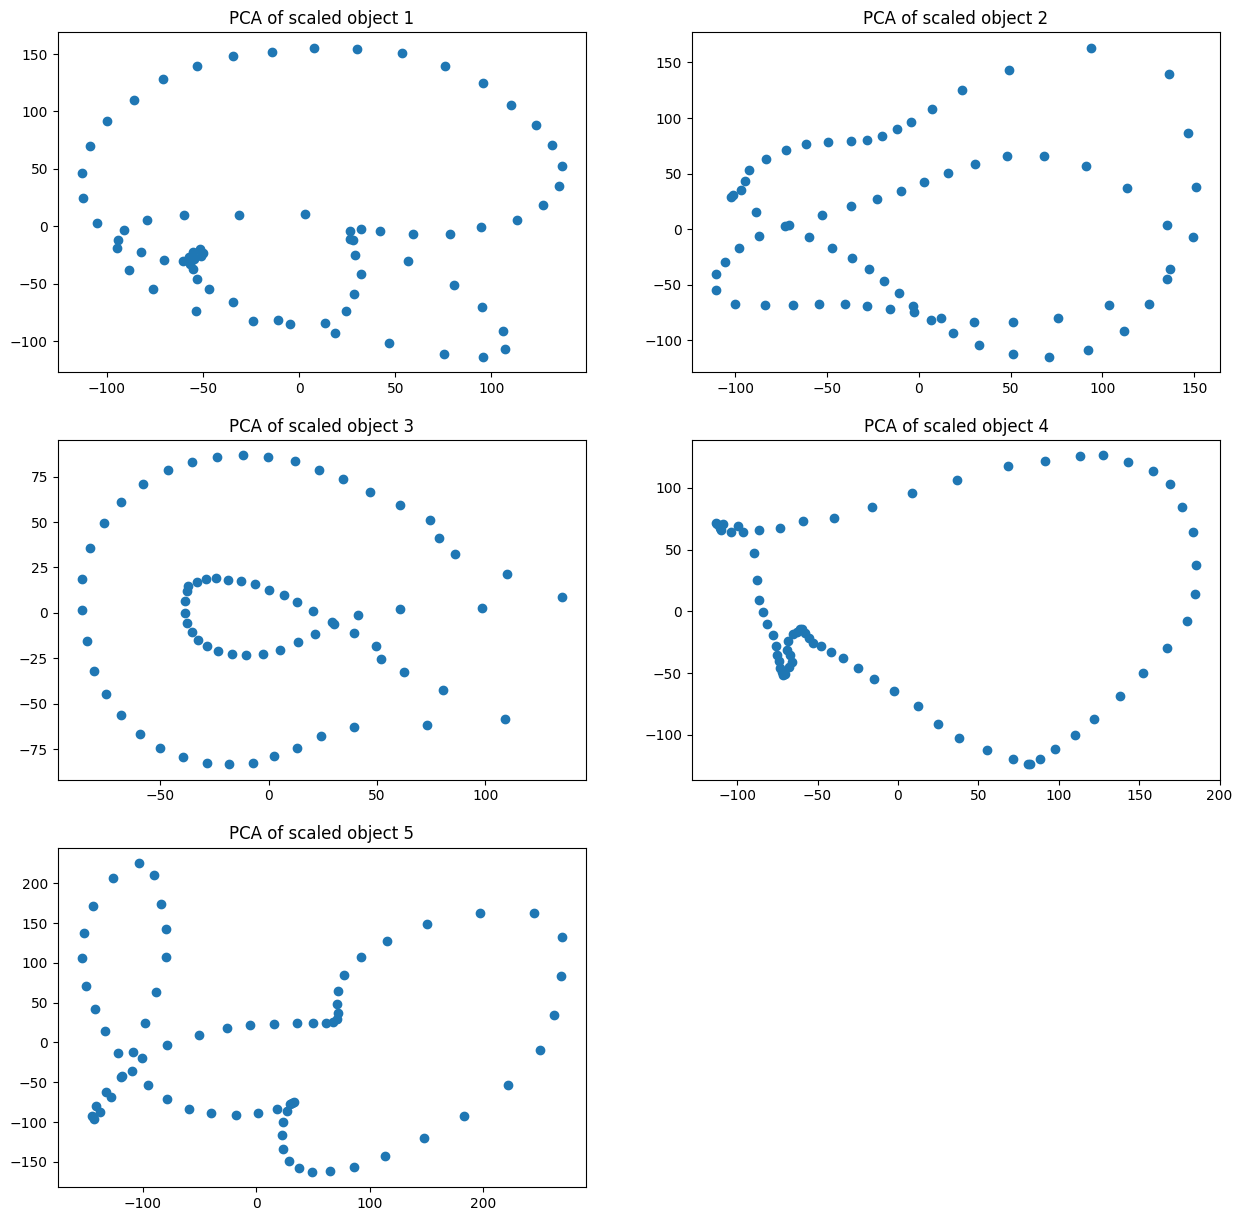

In [122]:
titles = [f"PCA of scaled object {i}" for i in range(1, 6)]
grid_scatter(scaled_objs_pca_image_set, rows=3, titles = titles)

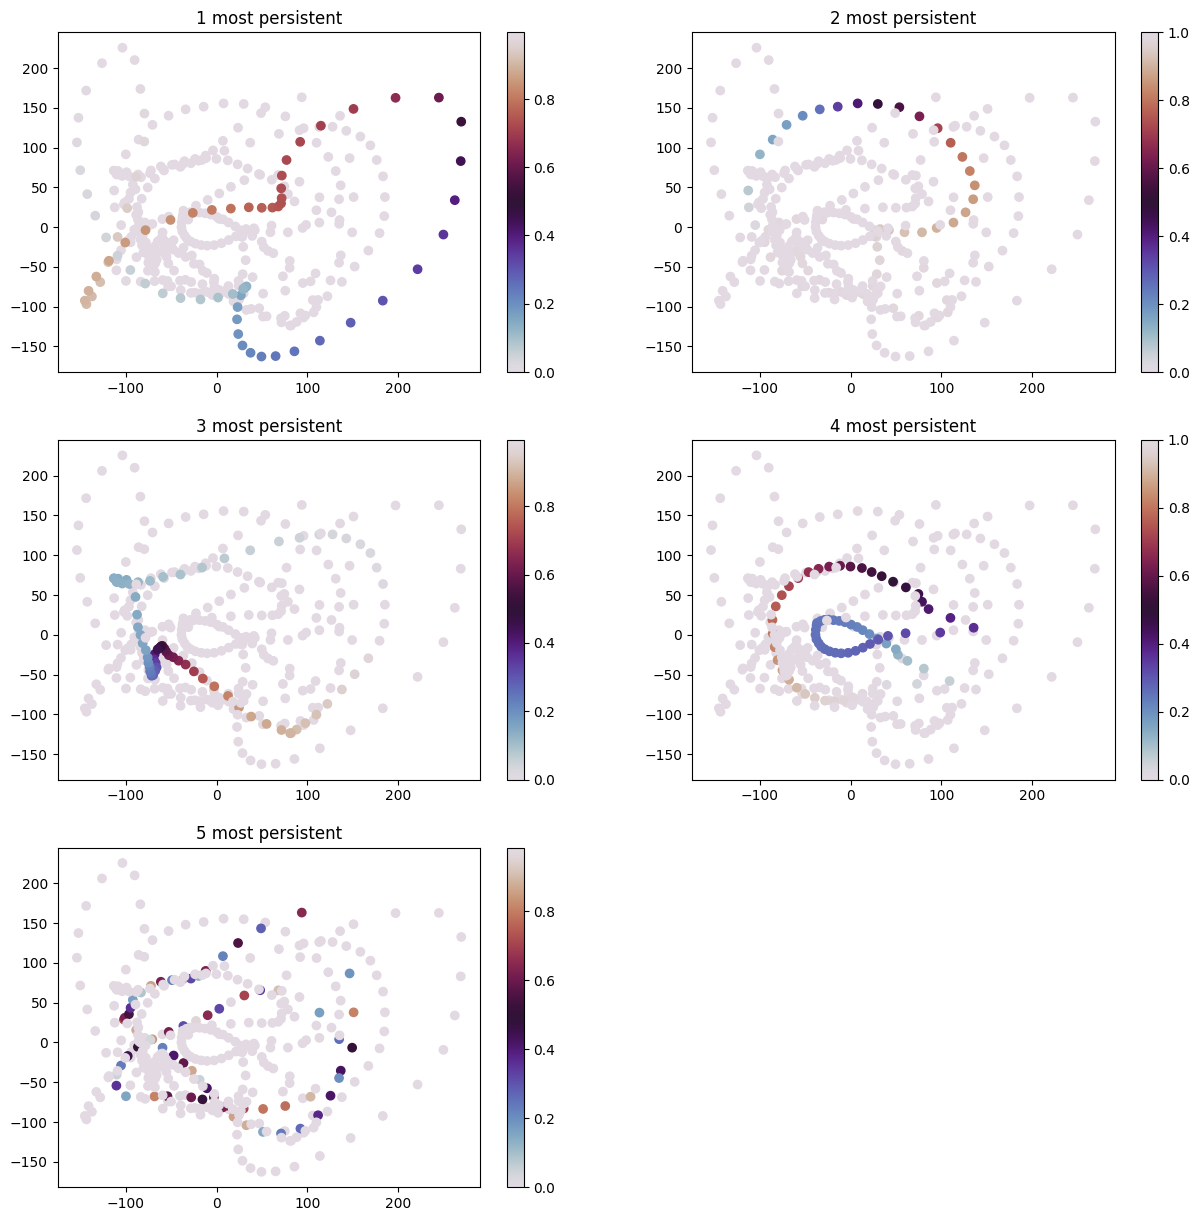

In [123]:
dset = scaled_joint_pca_image_set

rows = 3
n = len(coords)
cols = np.ceil(n/rows)

fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
cm = plt.cm.get_cmap('twilight')
for i in range(n):
    f = fig.add_subplot(rows, cols, i+1)
    sc = plt.scatter(dset[:, 0],dset[:, 1], c=coords[i], cmap=cm)
    f.set_title(f"{i+1} most persistent")
    plt.colorbar(sc)

plt.show()

## Flat Klein Bottle
#### As in the example of the flat torus, we can define a distance on the flat klein bottle. The interesting fact is that the klein bottle has torsion, so the dimension of the first homology changes depending on the coefficients.

In [132]:
def klein_norm(p,q):
    x_1, y_1 = p
    x_2, y_2 = q
    dx=abs(x_2-x_1)
    dy1=abs(y_2-y_1)
    dy2=abs(y_2-(1-y_1))
    if dx>0.5:
        dx=1.0-dx
        if dy2>0.5:
            return np.sqrt(dx**2+dy1**2)
        else:
            return np.sqrt(dx**2+dy2**2)
    else:
        return np.sqrt(dx**2+dy1**2)

def Kdistance_mat(dset):
    n = dset.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            D[i, j] = klein_norm(dset[i, :], dset[j, :])
            D[j, i] = D[i, j]
    return D

def Kto3D(data):
    T3D=np.zeros((data.shape[0],3), dtype=float)
    for i in range(T3D.shape[0]):
        T3D[i][0]= (3 + np.cos(np.pi*data[i][0])*np.sin(2*np.pi*data[i][1])-np.sin(np.pi*data[i][0])*np.sin(4*np.pi*data[i][1])) * np.cos(2*np.pi*data[i][0])
        T3D[i][1]=(3 + np.cos(np.pi*data[i][0])*np.sin(2*np.pi*data[i][1])-np.sin(np.pi*data[i][0])*np.sin(4*np.pi*data[i][1])) * np.sin(2*np.pi*data[i][0])
        T3D[i][2]= np.sin(np.pi*data[i][0])*np.sin(2*np.pi*data[i][1])+np.cos(np.pi*data[i][0])*np.sin(4*np.pi*data[i][1])
    return T3D

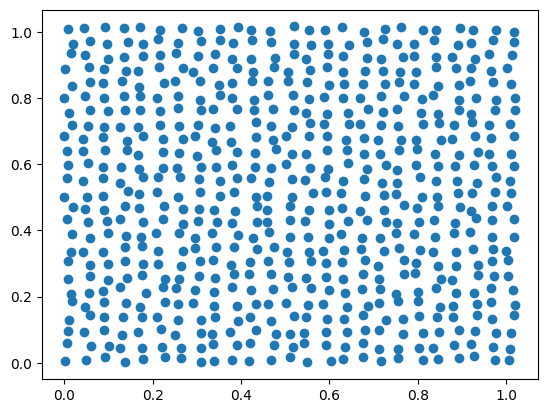

In [154]:
n=25 #n*n points in the klein bottle.
t = np.linspace(0,1,n)
x, y = np.meshgrid(t,t)
x = np.reshape(x, (n*n,1))
y = np.reshape(y, (n*n,1))
K = np.hstack([x, y]) + 0.02*np.random.random((n*n,2))

plt.scatter(K[:, 0], K[:, 1])

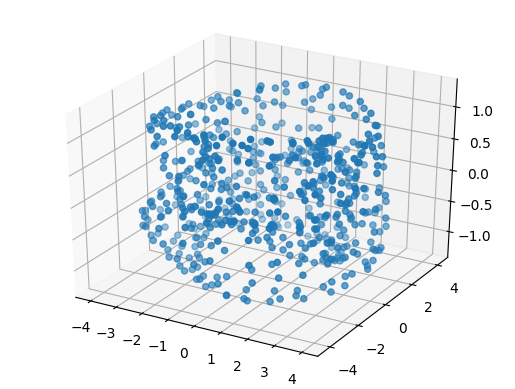

In [155]:
plot3d(Kto3D(K))

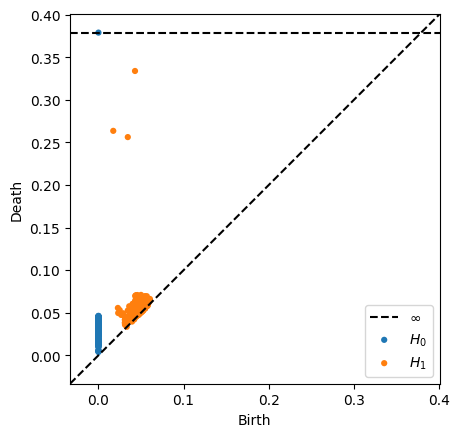

In [156]:
dist_mat = Kdistance_mat(K)

p = 41
result = ripser(dist_mat, coeff=p, do_cocycles=True, distance_matrix=True)
diagrams = result['dgms']
cocycles = result['cocycles']

# Dimension 0 and 1 diagrams
dgm0 = diagrams[0]
dgm1 = diagrams[1]

# plot diagrams of dimension 0 and 1
plot_diagrams([dgm0, dgm1], show=False)

In [157]:
sorted_idx = np.argsort(dgm1[:, 0] - dgm1[:, 1])

# top n cocycles
n = 3 # 3 most persistent cocycles
idxs = sorted_idx[:n]

In [158]:
# respective cocycles
top_cocycles = [cocycles[1][idx] for idx in idxs]
thresholds = [(dgm1[idx, 0], dgm1[idx, 1] - 1e-08) for idx in idxs ]

# one threshold for each one of them
rs = [convex(thresholds[i], 0.5) for i in range(n)]

In [159]:
coords = [circ_coord(dist_mat, top_cocycles[i], rs[i], p) for i in range(n)]

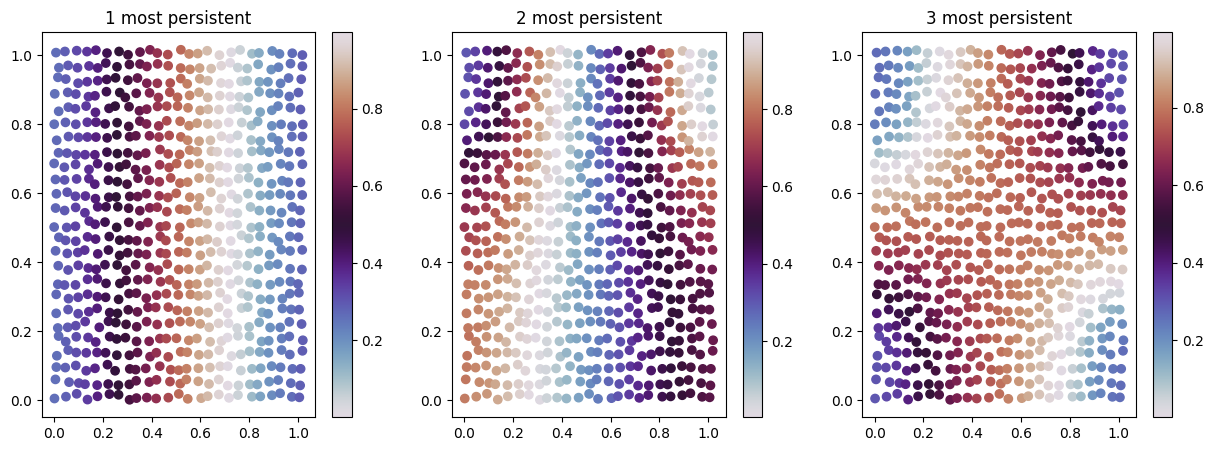

In [160]:
rows = 1
cols = np.ceil(n/rows)

fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(15)
cm = plt.cm.get_cmap('twilight')
for i in range(n):
    f = fig.add_subplot(rows, cols, i+1)
    sc = plt.scatter(K[:, 0],K[:, 1], c=coords[i], cmap=cm)
    f.set_title(f"{i+1} most persistent")
    plt.colorbar(sc)
plt.show()